# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello, World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum, where several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
January, 2022

## Dimuon mass spectrum calculation with Spark UDF using MapInArrow

In [ ]:
# Download the data (2 GB) if not yet available locally

! wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet

In [1]:
# Start the Spark Session
# This uses local mode for simplicity

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("dimuon mass")
         .master("local[4]")
         .config("spark.driver.memory", "2g")
         .getOrCreate()
        )


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/08 22:25:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/08 22:25:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Read data with the muon candidate events
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

path = "./"
df_muons = spark.read.parquet(path + "Run2012BC_DoubleMuParked_Muons.parquet")

df_muons.printSchema()
print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)

Number of events: 61540413


In [3]:
# Apply filters to the input data
# - select only events with 2 muons
# - select only events where the 2 muons have opposite charge

df_muons = df_muons.filter("nMuon==2").filter("Muon_charge[0] != Muon_charge[1]")


In [4]:
# Add the column Dimuon_mass to the DataFrame
# it will be used as output column, to work around the limitation that 
# mapInArrow needs to have the same input and output schema.

df_muons = df_muons.selectExpr("Muon_pt[0] pt0", "Muon_eta[0] eta0","Muon_phi[0] phi0", 
                               "Muon_pt[1] pt1", "Muon_eta[1] eta1","Muon_phi[1] phi1",
                               "float(0.0) as Dimuon_mass")

In [5]:
# this requires the library awkward arrays

# !pip install awkward
import awkward as ak
ak.__version__

'1.10.5'

In [6]:
from numpy import cosh, cos, sqrt

# This is where the dimuon mass is computed
# the candidate muon events are summed as 4-vectors in the Pt, eta, phi, m space
# and the invarian mass is computed
# This uses the library awkward arrray, serializing directly with arrow

def UDF_dimuonmass(iterator):
    for batch in iterator:
        chunk = ak.from_arrow(batch)
        
        # Calculate the dimuon mass using the updated array operations in Awkward 2.x
        dimuon_mass = sqrt(2 * chunk["pt0"] * chunk["pt1"] *
                           (cosh(chunk["eta0"] - chunk["eta1"]) - cos(chunk["phi0"] - chunk["phi1"])))
        
        # Constructing a new record array that will be the output, only "Dimuon_mass" will be used at the end
        placeholder = ak.zeros_like(dimuon_mass)
        
        # Zip together the placeholders with the actual dimuon_mass values
        out = ak.zip({
            "pt0": placeholder,
            "eta0": placeholder,
            "phi0": placeholder,
            "pt1": placeholder,
            "eta1": placeholder,
            "phi1": placeholder,
            "Dimuon_mass": dimuon_mass
        })
        
        # Convert back to an Arrow table for PySpark. The 'to_batches()' function is part of pyarrow.Table, not Awkward Array.
        yield from ak.to_arrow_table(out).to_batches()


In [7]:
# apply the UDF with arrow to compute the dimuon mass spectrum

df_with_dimuonmass = df_muons.mapInArrow(UDF_dimuonmass, df_muons.schema)

In [8]:
# This defines the DataFrame transformation to compute the Dimuon mass spectrum
# The result is a histogram with (energy) bin values and event counts foreach bin

# Requires sparkhistogram
# See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md 
from sparkhistogram import computeHistogram

# histogram parameters
min_val = 0.25
max_val = 300
num_bins = 30000

# use the helper function computeHistogram in the package sparkhistogram
histogram_data = computeHistogram(df_with_dimuonmass, "Dimuon_mass", min_val, max_val, num_bins) 


In [9]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 103 ms, sys: 6.31 ms, total: 110 ms
Wall time: 21.3 s


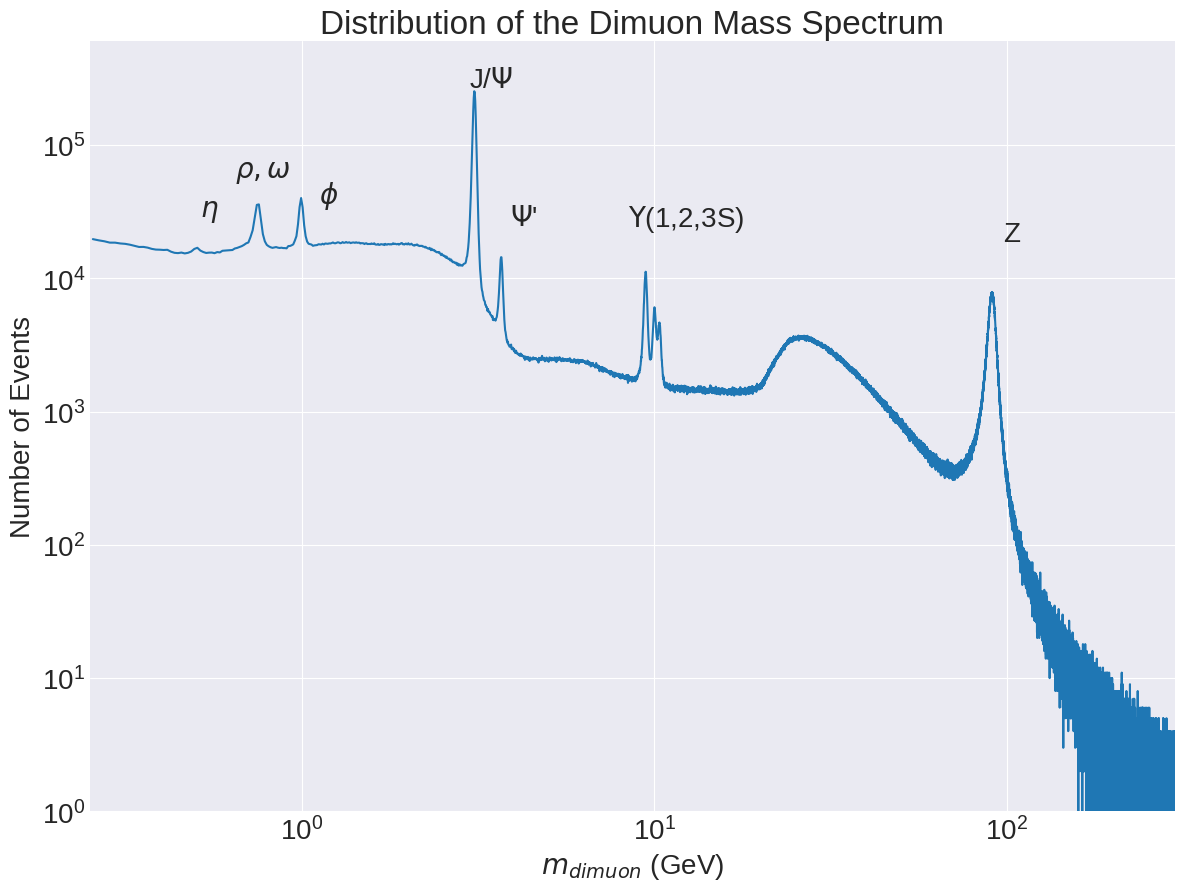

In [10]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas["value"]
y = histogram_data_pandas["count"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()

In [11]:
spark.stop()